# Maximum entropy

In this notebook, we will demonstrate how to apply the method of maximum entropy to a simulated data of a neural spike train system. 

In our simple simulated system, we will take $N=9$ neurons that any moment are firing ($+1$) or not firing ($-1$), so that the state of the system at some time, $\vec{x}$ is a vector of length $N$ with each component $x_i \in \{-1,1\}$. We take a simple update rule, and sample at well spaced time intervals. We end up with some set of empirical measurements, just as we would if we had performed an experiment.

For an example of the principle of maximum entropy applied to actual neural measuerments, see https://www.nature.com/articles/nature04701

First we set up and run the simulation:

In [1]:
using Random
using Plots
using StatsBase
f_rate = 0.2
N = 9

spin_object = ones(Int64,N);

function update_rule!(spin_object,p)
    N,f_rate = p
    idxs = randperm(N)[1:3]
    
    if spin_object[idxs[2]] == 1 
        f_rate *= sqrt(2)
    end
    
    if spin_object[idxs[3]] == 1 
        f_rate *= sqrt(2)
    end
    f_rate = minimum([f_rate,1.0])
    spin_object[idxs[1]] = sample([-1,1], Weights([1-f_rate,f_rate]))
end

# now simulate
saved_data = []
for _ = 1:10_000
    for _ = 1:10_000
        update_rule!(spin_object,(N,f_rate))
    end
    push!(saved_data,copy(spin_object))
end

# enumerate the state space - useful for later
options = [[1],[-1]]
for i = 1:(N-1)
    options = vcat([vcat(o,[1]) for o in options],[vcat(o,[-1]) for o in options])
end

Now that we have simulated the system, let us briefly examine the data. Each state has been observed some number of times. We can plot a histogram of those numbers

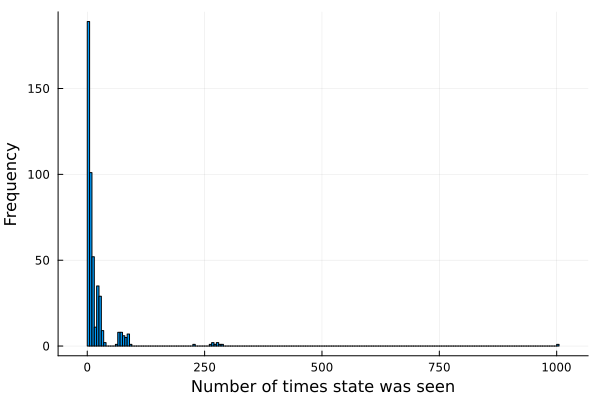

In [2]:
cm = countmap(saved_data) # a handy function that maps a state to the number of times it was seen.
histogram(collect(values(cm)),label=false,xlabel="Number of times state was seen",ylabel="Frequency")

The histogram shows that one state is seen often, but most states have only been observed a handful of times. We can find the state that is observed the most:

In [3]:
println("Most observed state = ", collect(keys(cm))[argmax(collect(values(cm)))])

Most observed state = [-1, -1, -1, -1, -1, -1, -1, -1, -1]


Showing that the most observed state is the one where no neurons are firing. Having observed this state over 1000 times, we probably have a good idea of how frequently it occurs. However, many of the states have seldom been observed, and therefore our empirical distribution is likely a poor estimate of their true distribution.

To test this, we can split the data into smaller parts and see how this affects the empirical distribution:

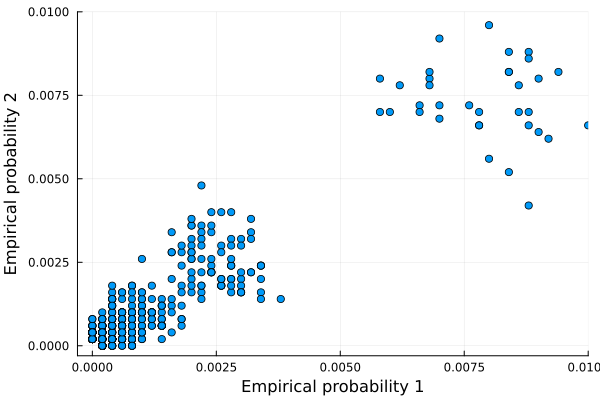

In [21]:
subsample_data1 = saved_data[1:2:end]
subsample_data2 = saved_data[2:2:end];
sub_cm1 = countmap(subsample_data1)
sub_cm2 = countmap(subsample_data2)
prob1 = [(haskey(sub_cm1,k) ? sub_cm1[k] : 0.0) for k in keys(cm)]/length(subsample_data1)
prob2 = [(haskey(sub_cm2,k) ? sub_cm2[k] : 0.0) for k in keys(cm)]/length(subsample_data2)

scatter(prob1,prob2,xlims=(-0.0003,0.01),ylims=(-0.0003,0.01),label=false,xlabel="Empirical probability 1",ylabel="Empirical probability 2")

As you can see, there is a lot of uncertainty, particularly for small frequency values. This suggests that we haven't sampled enough to get good estimates. Moreover this problem will get (exponentially) worse if we consider more neurons $N$.

## Applying the maximum entropy principle

The idea behind the principle of maximum entropy is that, even if we have too few empirical samples to completely recover the distribution, we may well have enough data to measure certain observables, such as means, covariences, and so on. Therefore, to approximate the true distribution, we should find the distribution which is consistent with these measurements, but otherwise has maximum entropy. To illustrate the point, consider once again splitting the data, but this time computing the expected state of a neuron, i.e. wether it is firing or not:
$$\frac{1}{N}\sum_i \langle x_i \rangle = \mu$$

We will take several random subsamples of the data and compare 

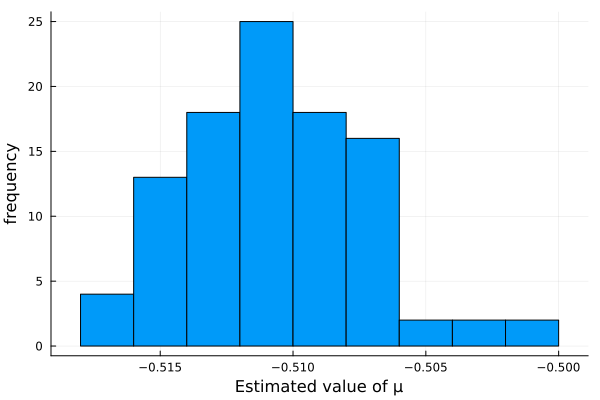

In [5]:
mean_arr = []
for i = 1:100
    idx_rand = randperm(length(saved_data))[1:2:end] # a random subset
    subsample_data = saved_data[idx_rand]
    push!(mean_arr, mean(mean.(subsample_data)))
end
histogram(mean_arr,label=false,xlabel="Estimated value of μ",ylabel="frequency")

As you can see, we have enough data to get a reasonable estimate of $\mu$. Let us therefore apply the principle of maximum entropy, with $\mu$ being the sole observable we wish to hold fixed.

We want to maximize the entropy, with constraints: $L[p] = \sum_{\vec{x}} -p(\vec{x}) \log p(\vec{x}) + \lambda  \sum_{\vec{x}} p(\vec{x}) \vec{x} \cdot 1 + \eta \sum_\vec{x} p(\vec{x}) $
which we can do by differentiation with respect to $p(\vec{x}^*)$,

$$\partial L[p]/\partial p(\vec{x}^*) = - \log p(\vec{x}^*) - 1 + \lambda \vec{x}^* \cdot 1 + \eta $$

This implies that

$$ p(\vec{x}) = \exp[-\lambda \vec{x} \cdot 1]/ Z = \frac{1}{Z} \prod_i  \exp[-\lambda x_i],$$

with 
$$Z = \sum_{\vec{x}} \prod_i  \exp[-\lambda x_i] = (e^\lambda + e^{-\lambda})^N $$ 

Where we note that the factorization of $p$ shows that the cells are now firing independently. We have that

$$ \langle x_i \rangle = \left[(-1)\times e^\lambda + (+1) \times e^{-\lambda}\right]/ (e^\lambda + e^{-\lambda})  = -\tanh(\lambda)$$

In [6]:
p_indep(x,λ) = exp(-λ*sum(x))/(exp(λ)+exp(-λ))^N
λ_emp = atanh(-mean( mean.(saved_data)))

0.5639619414314861

Having computed $\lambda$, we now have the maximum entropy distribution, $p$, which we can sample from:

In [7]:
model_data = [options[sample(Weights(p_indep.(options,λ_emp)))] for _ = 1:10_000];

Importantly, we now need to assess whether our distribution is consistent with the data. It will agree on the mean firing rate, $\mu$, by construction. The question is whether it agrees on other observables. If the only important degree of freedom the system fixes is the firing rate then the maximum entropy distribution should be consistent. If the system has other important statistics that are fixed, then it may not.

Let us go beyond the mean, and consider the number of neurons that are firing at any given time. There is an empirical distribution of this number, as well as the exact maximum entropy prediction. Our maximum entropy distribution is simple enough that we can compute the analytic expression of this number: as neurons are independent it is just a binomial distribution with parameter $p = e^{-\lambda}/(e^\lambda + e^{-\lambda})$ on $N$ variables.

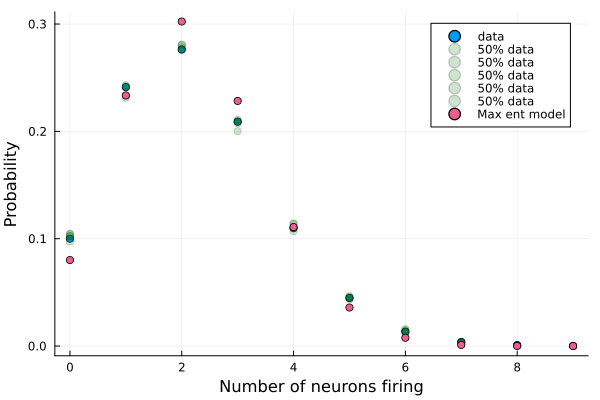

In [8]:
mean_fire_data = [sum((s.+1)./2) for s in saved_data]
cm_data = countmap(mean_fire_data)
scatter(collect(keys(cm_data)),collect(values(cm_data))/length(saved_data),label="data")

bp = exp(-λ_emp)/(exp(λ_emp)+exp(-λ_emp))
binomial_d = [binomial(N,k) * bp^k * (1-bp)^(N-k) for k = 0:N]

for _ = 1:5
    reduced_permed_data = mean_fire_data[randperm(length(saved_data))[1:Int64(round(length(saved_data)/2))]]

    cm_ballpark = countmap(reduced_permed_data)
    cv = collect(values(cm_ballpark))
    scatter!(collect(keys(cm_ballpark)),cv/sum(cv),label="50% data",c=:green,alpha=0.2)
end
scatter!(0:N,binomial_d,label="Max ent model",xlabel="Number of neurons firing",ylabel="Probability")

We see that it doesn't explain the empirical distribution ...

Additionally, we could think of other ways to test whether the model fits the data. Even though our empirical samples for the entire system is bad, we could restrict to a subset of the system where the empirical samples may be more accurate. For instance take a subset of the neurons and look at their empirical frequency compared to the maximum entropy model:

In [9]:
neuron_subset_data = [s[1:5] for s in saved_data]
cm_data = countmap(neuron_subset_data)
emp_freq = collect(values(cm_data))/length(saved_data);
model_freq = [bp^(sum(k.==1)) * (1-bp)^(sum(k.==-1)) for k in collect(keys(cm_data))];

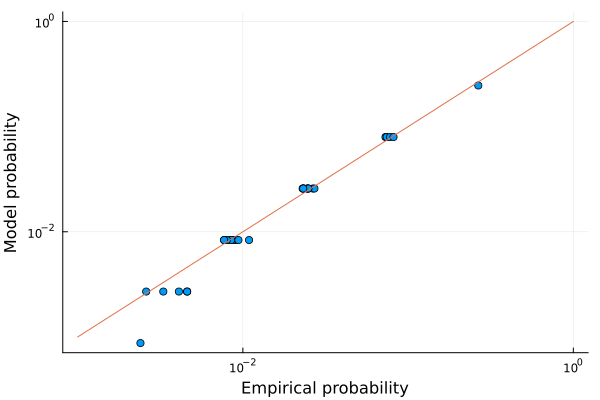

In [10]:
scatter(collect(values(cm_data))/length(saved_data),model_freq,xaxis=:log10,yaxis=:log10,label=false)
plot!([10^-3,10^0],[10^-3,10^0],label=false,xlabel="Empirical probability", ylabel="Model probability")

Again, we see that the max ent model does not capture all the variation of the data.

## Additional constaints

Let us add an additional pairwise constraint 
$$\sum_{i\neq j} \langle x_i x_j \rangle = \theta$$
We now have constraints: $L[p] = \sum_{\vec{x}} -p(\vec{x}) \log p(\vec{x}) + \lambda_1  \sum_{\vec{x}} p(\vec{x}) \vec{x} \cdot 1 + \lambda_2  \sum_{\vec{x}} p(\vec{x}) (\vec{x} \cdot 1)^2 + \eta \sum_\vec{x} p(\vec{x}) $
which we can do by differentiation with respect to $p(\vec{x}^*)$,

$$\partial L[p]/\partial p(\vec{x}^*) = - \log p(\vec{x}^*) - 1 + \lambda_1 \vec{x}^* \cdot 1 + \lambda_2 (\vec{x}^* \cdot 1)^2 + \eta $$

This implies that

$$ p(\vec{x}) = \exp[-\lambda_1 \vec{x} \cdot 1 - \lambda_2 ( \vec{x} \cdot 1)^2 ]/ Z ,$$

with 
$$Z = \sum_{\vec{x}} \exp[-\lambda_1 \vec{x} \cdot 1 - \lambda_2 ( \vec{x} \cdot 1)^2 ]$$ 

This is not factorizable into independent components as before. We could still analytically solve for $\lambda_1$ and $\lambda_2$, but in general such calculations are not possible. Here, we demonstrate a numerical approach

In [11]:
p_pairwise_ = (x,λ1,λ2) -> exp(-λ1*sum(x)-λ2*sum(x)^2)

#17 (generic function with 1 method)

In [12]:
function params_to_observables(λ1,λ2)
    p0 = p_pairwise_.(options,λ1,λ2)
    Z0 = sum(p0)
    Ex = sum(mean.(options).*p0)/Z0
    Ex2 = sum(mean.(options).^2 .*p0)/Z0
    return Ex, Ex2
end
e1 = mean(mean.(saved_data))
e2 = mean(mean.(saved_data).^2)

0.35973333333333324

Now optimize over $\lambda_1$ and $\lambda_2$ until params look like the data

In [13]:
using Optim
res = optimize(x->sum((params_to_observables(x[1],x[2]) .- [e1,e2]).^2),
            [λ_emp,0.0], Optim.LBFGS(),Optim.Options(iterations=10))
println(res)
λ1,λ2 =  Optim.minimizer(res)

 * Status: success

 * Candidate solution
    Final objective value:     7.300631e-16

 * Found with
    Algorithm:     L-BFGS

 * Convergence measures
    |x - x'|               = 9.88e-08 ≰ 0.0e+00
    |x - x'|/|x'|          = 2.20e-07 ≰ 0.0e+00
    |f(x) - f(x')|         = 1.50e-15 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 2.06e+00 ≰ 0.0e+00
    |g(x)|                 = 4.94e-11 ≤ 1.0e-08

 * Work counters
    Seconds run:   0  (vs limit Inf)
    Iterations:    8
    f(x) calls:    28
    ∇f(x) calls:   28



2-element Vector{Float64}:
  0.44995533260508874
 -0.014298559185693803

In [14]:
println("Observables under max ent model = ", params_to_observables(λ1,λ2)) # These should match!
println("Observables measured in data = ", (e1,e2))

Observables under max ent model = (-0.510911128740611, 0.359733312857399)
Observables measured in data = (-0.5109111111111113, 0.35973333333333324)


Now that we have $\lambda_1$ and $\lambda_2$ we construct the max ent distribution function:

In [15]:
Z = sum(p_pairwise_.(options,λ1,λ2))
p_pairwise = x -> p_pairwise_(x,λ1,λ2)/Z

#21 (generic function with 1 method)

Once again, we can compare the maximum entropy distribution to data. First we can again look at the distribution of how many neurons are firing at one time. Note this distribution is a statistic that we did not fix in our max ent fitting:

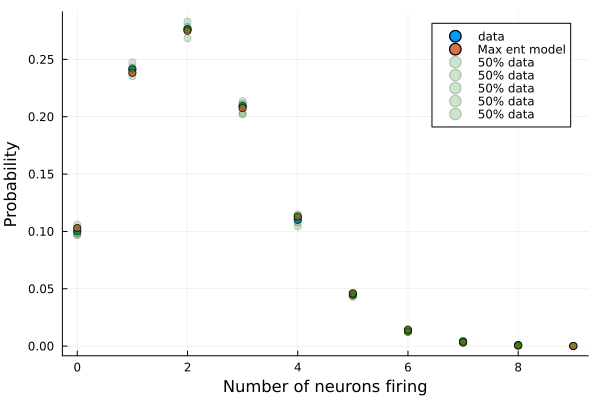

In [16]:
mean_fire_data = [sum((s.+1)./2) for s in saved_data]
n_fire_model = zeros(N+1)
for o in options
    n_fire_model[(sum((o.+1)) >> 1) + 1] += p_pairwise(o)
end

cm_data = countmap(mean_fire_data)

scatter(collect(keys(cm_data)),collect(values(cm_data))/length(saved_data),label="data")
scatter!(0:N,n_fire_model,label="Max ent model")


for _ = 1:5
    reduced_permed_data = mean_fire_data[randperm(length(saved_data))[1:Int64(round(length(saved_data)/2))]]

    cm_ballpark = countmap(reduced_permed_data)
    cv = collect(values(cm_ballpark))
    scatter!(collect(keys(cm_ballpark)),cv/sum(cv),label="50% data",c=:green,alpha=0.2)
end
scatter!(xlabel="Number of neurons firing",ylabel="Probability")

This time the agreement is greatly improved!

Let us also, once again, take a subset of the neurons and look at their empirical frequency compared to the maximum entropy model:

In [17]:
n_keep = 5
neuron_subset_data = [s[1:n_keep] for s in saved_data]
cm_data = countmap(neuron_subset_data)
emp_freq = collect(values(cm_data))/length(saved_data);

model_freq = zeros(length(emp_freq))
kk = collect(keys(cm_data))
for o in options
    idx = findfirst([all(o[1:n_keep] .== k) for k in kk])
    if !isnothing(idx)
        model_freq[idx] += p_pairwise(o)
    end
end

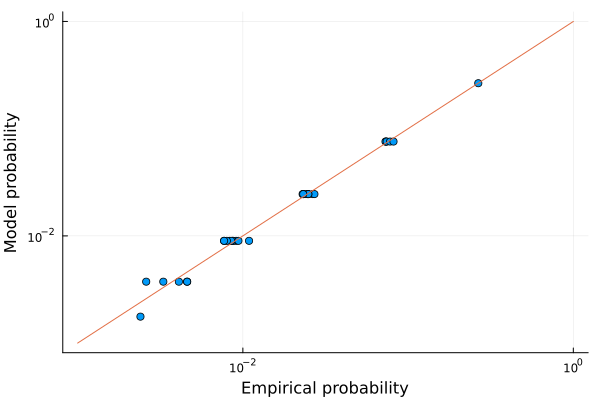

In [18]:
scatter(emp_freq,model_freq,xaxis=:log10,yaxis=:log10,label=false)
plot!([10^-3,10^0],[10^-3,10^0],label=false,xlabel="Empirical probability", ylabel="Model probability")

The predictions are now much improved and any discrepancies could reasonably be down to sampling error (Q: how would one check this?)